In [0]:
from google.colab import drive, files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd "/content/drive/My Drive/Colab Notebooks/deep-learning-group"

/content/drive/My Drive/Colab Notebooks/deep-learning-group


In [0]:
import autoreload
%load_ext autoreload

In [0]:
%reload_ext autoreload

In [0]:
import glob
import cv2
import numpy as np
import os


from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import csv
import helpers
import pandas as pd

In [0]:
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/dataset'

batch_size_train = 200
val_size_train = 30

colorMode = 'rgb'
classMode = "categorical"
imgSize = 64


datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1, 
                             rescale=1./255,
                             zoom_range=0.3,
                             validation_split=0.2,
                             horizontal_flip=True)

In [0]:
train_generator = datagen.flow_from_directory(DATA_DIR,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size_train,
                                            subset='training')

validation_generator = datagen.flow_from_directory(DATA_DIR,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size_train,
                                            subset='validation')

Found 1044 images belonging to 17 classes.
Found 254 images belonging to 17 classes.


**Callback functions list**

In [0]:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0.001,
                           patience=5)

**Simple CNN model**

In [0]:
cvsores_1 = []
filepath_1 = "Weights_1.best.hdf5"
checkpoint_1 = ModelCheckpoint(filepath_1, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

logpath_1 = "Model_1_history.csv"
log_1 = CSVLogger(logpath_1, append=True)

callback_list_1 = [early_stop, checkpoint_1, log_1]

def get_compiled_model_1(optimizer='adam', loss='categorical_crossentropy'):
  keras.backend.clear_session()
  model = Sequential([
                      Conv2D(32, activation='relu', kernel_size=3, input_shape=(imgSize, imgSize, 3)),
                      MaxPooling2D(pool_size=(2, 2)),
                      Conv2D(32, activation='relu', kernel_size=3),
                      MaxPooling2D(pool_size=(2, 2)),
                      Flatten(),
                      Dense(128, activation='relu'),
                      Dense(17, activation='softmax')
  ])
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  return model

In [0]:
model_1 = get_compiled_model_1()

history = model_1.fit_generator(train_generator,
            steps_per_epoch=100,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=30,
            callbacks=callback_list_1)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 2.1977 - accuracy: 0.3247
Epoch 00001: val_accuracy improved from -inf to 0.45144, saving model to Weights_1.best.hdf5
100/100 [==============================] - 128s 1s/step - loss: 2.1977 - accuracy: 0.3247 - val_loss: 1.8170 - val_accuracy: 0.4514
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 1.5074 - accuracy: 0.5327
Epoch 00002: val_accuracy improved from 0.45144 to 0.50682, saving model to Weights_1.best.hdf5
100/100 [==============================] - 126s 1s/step - loss: 1.5074 - accuracy: 0.5327 - val_loss: 1.6223 - val_accuracy: 0.5068
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 1.2651 - accuracy: 0.6034
Epoch 00003: val_accuracy improved from 0.50682 to 0.53622, saving model to Weights_1.best.hdf5
100/100 [==============================] - 128s 1s/step - loss: 1.2651 - accuracy: 0.6034 - val_loss: 1.5459 - val_accuracy: 0.5362
Epoch 4/30
100/100 [===========

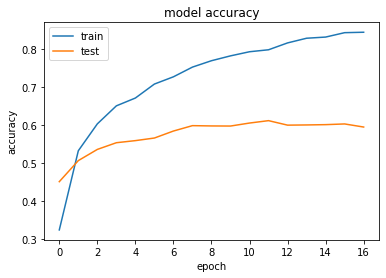

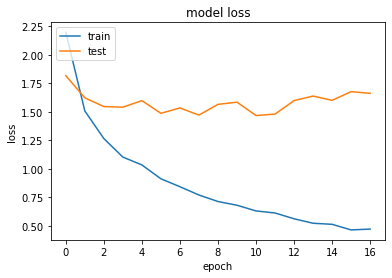

In [0]:
log_data = pd.read_csv(logpath_1)
helpers.plotTrainingHistory(log_data)

**Simple model using transfer learning**

In [0]:
cvscores_2 = []
def get_compiled_model_2():
  keras.backend.clear_seesion()
  baseModel = VGG16(weights='imagenet',
                    include_top=False,
                    input_tensor=Input(shape=(imgSize, imgSize, 3)))
  
  for layer in baseModel.layers[:-5]:
    layer.trainable = False
  
  